# Cats and Dogs using Transfer Learning from InceptionV3

We will leverage the trained layers from InceptionV3.

1. Get superior convolutional layers from pre trained model
2. Attatch dense layers to the end of these convolutional layers
3. Train the dense network

We will effectively be using the results of training a very deep neural network and tweaking it for our dataset.

## Setup of pre trained model

1. Set the input shape to fit our application. We will be setting this to (150,150,3)
2. Pick and "freeze" the convolution layers to use the features it has learnt already
3. Add dense layers which we will train

In [1]:
# Fetch the pre trained weights of InceptionV3
# Remove the fully connected layer at the end
# Specify the input shape that the model will accept
# Freeze the weights of these layers as they have been trained already

# Step 1: Fetching the weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

--2023-08-05 20:27:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   172MB/s    in 0.5s    

2023-08-05 20:27:28 (172 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Inititialise the base by :
# Step 2 : Set the input shape and remove the layers we dont need

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                               include_top = False, # We will make our own top layer
                               weights=None) # Weights none for now load them in the next line

pre_trained_model.load_weights(local_weights_file)

# Freeze the weights
for layer in pre_trained_model.layers:
    layer.trainable = False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Look at how impressive this pre trained model is
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

## Designing the model

We will need to check the output shape. Using a lower layer will mean a smaller output shape, lets aim for an reasonably sized output shape to feed into our Dense neural network

In [4]:
# Lets use "mixed7" as the last layer of the base model
last_layer = pre_trained_model.get_layer("mixed7")
print(f"Last Layer output shape : ", last_layer.output_shape)
last_output = last_layer.output

Last Layer output shape :  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten() (last_output)

# Add a fully connected layer with 1024 hidden units and relu activation
x = layers.Dense(1024, activation="relu")(x)

# Add dropout with rate 0.2
x = layers.Dropout(0.2)(x)

# Add our final output layer
x = layers.Dense(1, activation="sigmoid")(x)

### Finally, append the dense network to the base model
model = Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001), # Smaller learning rate as we expect high accuracy from start
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

## Prepare the dataset

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-08-05 20:27:46--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   159MB/s    in 0.4s    

2023-08-05 20:27:46 (159 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 25s - loss: 0.3114 - accuracy: 0.8735 - val_loss: 0.1780 - val_accuracy: 0.9310 - 25s/epoch - 249ms/step
Epoch 2/20
100/100 - 14s - loss: 0.2141 - accuracy: 0.9130 - val_loss: 0.1225 - val_accuracy: 0.9550 - 14s/epoch - 144ms/step
Epoch 3/20
100/100 - 14s - loss: 0.1911 - accuracy: 0.9230 - val_loss: 0.0939 - val_accuracy: 0.9620 - 14s/epoch - 145ms/step
Epoch 4/20
100/100 - 14s - loss: 0.1829 - accuracy: 0.9275 - val_loss: 0.0961 - val_accuracy: 0.9660 - 14s/epoch - 138ms/step
Epoch 5/20
100/100 - 14s - loss: 0.1424 - accuracy: 0.9390 - val_loss: 0.1510 - val_accuracy: 0.9430 - 14s/epoch - 137ms/step
Epoch 6/20
100/100 - 14s - loss: 0.1608 - accuracy: 0.9450 - val_loss: 0.1001 - val_accuracy: 0.9580 - 14s/epoch - 137ms/step
Epoch 7/20
100/100 - 15s - loss: 0.1405 - accuracy: 0.9425 - val_loss: 0.0823 - val_accuracy: 0.9680 - 15s/epoch - 147ms/step
Epoch 8/20
100/100 - 14s - loss: 0.1409 - accuracy: 0.9480 - val_loss: 0.0902 - val_accuracy: 0.9670 - 14s/epoch - 137

## Evaluating the results

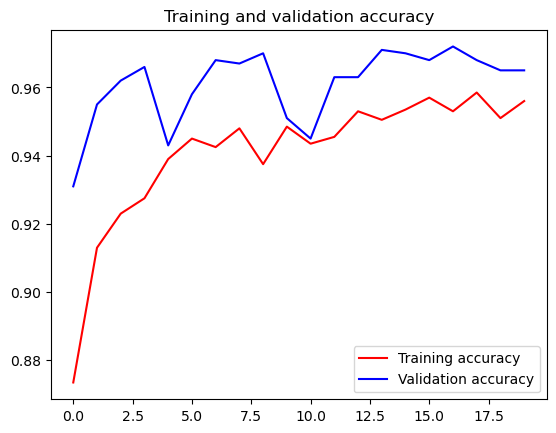

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()